# Predicting User Churn from Feature Matrix

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE

In [11]:
sns.set(style="whitegrid")

# Load the data
PROCESSED_PATH = "../data/processed/parquet/"
df = pd.read_parquet(PROCESSED_PATH + "user_feature_matrix.parquet")

# ─────────────────────────────────────────────
# 1️⃣ Feature Selection
# ─────────────────────────────────────────────

In [12]:
features = ["avg_minutes", "avg_data", "avg_satisfaction", "age", "is_enterprise"]
target = "churned"

X = df[features]
y = df[target]

In [20]:
# Show class distribution
print("Churn Class Distribution:\n", y.value_counts(normalize=True))

Churn Class Distribution:
 churned
0    0.866
1    0.134
Name: proportion, dtype: float64


# ─────────────────────────────────────────────
# 2️⃣ Train-Test Split
# ─────────────────────────────────────────────

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25, random_state=42)

# ─────────────────────────────────────────────
# 3️⃣ Feature Scaling
# ─────────────────────────────────────────────

In [14]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ─────────────────────────────────────────────
# 4️⃣ Train Model
# ─────────────────────────────────────────────

In [35]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_scaled, y_train)

print("After SMOTE:\n", pd.Series(y_resampled).value_counts())

After SMOTE:
 churned
0    325
1    325
Name: count, dtype: int64


In [ ]:
model = RandomForestClassifier(class_weight='balanced', random_state=42)
model.fit(X_resampled, y_resampled)

# ─────────────────────────────────────────────
# 5️⃣ Evaluation
# ─────────────────────────────────────────────

In [31]:
y_pred = model.predict(X_test_scaled)
y_proba = model.predict_proba(X_test_scaled)[:, 1]

print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.81      0.82       108
           1       0.05      0.06      0.05        17

    accuracy                           0.70       125
   macro avg       0.45      0.43      0.44       125
weighted avg       0.74      0.70      0.72       125

Confusion Matrix:
 [[87 21]
 [16  1]]
ROC AUC: 0.41476034858387795


# ─────────────────────────────────────────────
# 6️⃣ ROC Curve
# ─────────────────────────────────────────────

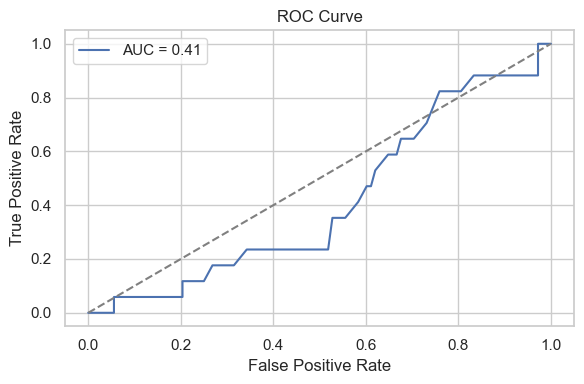

In [32]:
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_proba):.2f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.tight_layout()
plt.show()

# ─────────────────────────────────────────────
# 7️⃣ Feature Importance
# ─────────────────────────────────────────────

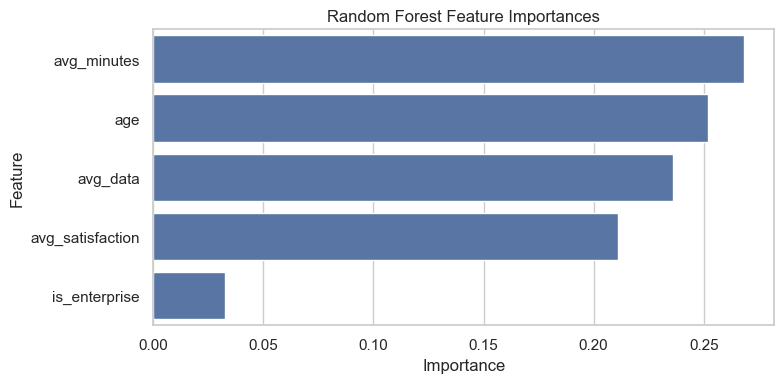

In [33]:
importances = model.feature_importances_
coeffs = pd.DataFrame({
    "Feature": features,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

plt.figure(figsize=(8, 4))
sns.barplot(data=coeffs, x="Importance", y="Feature")
plt.title("Random Forest Feature Importances")
plt.tight_layout()
plt.show()

In [36]:
import joblib
joblib.dump(model, "../models/churn_model.pkl")
joblib.dump(scaler, "../models/churn_scaler.pkl")

['../models/churn_scaler.pkl']